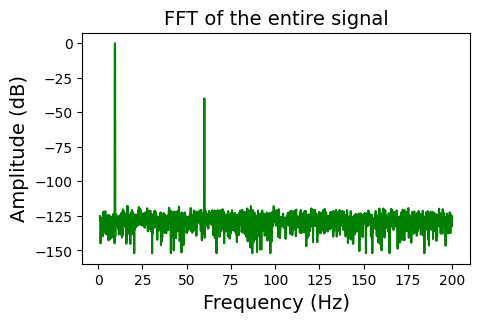

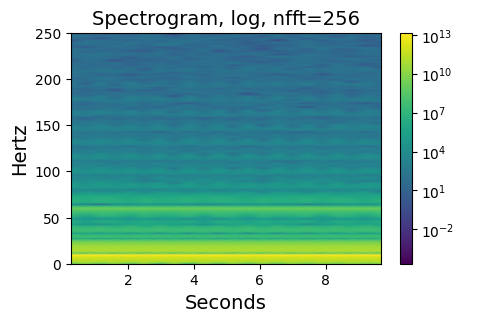

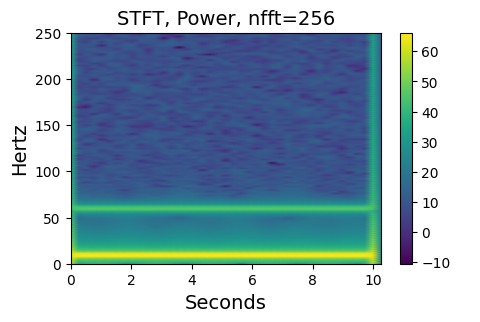

In [1]:
"""
    rfft-stft-test-1.ipynb
"""
import  numpy as np
import  matplotlib.pyplot as plt
from    scipy.signal import spectrogram, stft, windows


def main():

    t_buf_size = 5000
    samples_per_second = 500

    freq_low = 1
    freq_high = 200

    t_buf: np.ndarray = np.zeros(t_buf_size, dtype=int)
    t_buf = simulated_data(t_buf_size, samples_per_second)

    dt = 1.0 / float(samples_per_second)
    t_max = float(t_buf_size) / float(samples_per_second)     # max seconds of time-domain data
    t = np.linspace(0, t_max, samples_per_second, endpoint=False)


    # ========== fft of entire signal:
    bin_width_Hz = float(samples_per_second) / float(t_buf_size)
    # --- array of bin center freqs (with no dc element) (length num_samples/2)
    bin_center_freqs: np.ndarray = np.fft.rfftfreq(t_buf_size, dt)
    # --- select a range of freqs (as limited by freq_low/high):
    #       (get indices of elements in bin_center_freqs array)
    range_indices: tuple[np.ndarray[any, np.dtype[np.signedinteger]], ...] \
        = np.where(np.logical_and(np.greater_equal(bin_center_freqs, freq_low),
                                    np.less_equal(bin_center_freqs, freq_high)))
    # --- array of freqs in Hz, limited to flow/fhigh range:
    range_freqs = bin_center_freqs[range_indices]
    # --- scale sample data for fft:
    sample_buf: np.ndarray = t_buf[:t_buf_size] / 419430000
    # --- fft-window function:
    sample_buf *= windows.hann(t_buf_size, sym=False)
    #   with amplitude normalization:
    sample_buf *= 2.00
    # --- calc rfft (real input):
    raw_fft: np.ndarray[any, np.dtype[np.complexfloating[_64Bit, _64Bit]]]  \
        = np.fft.rfft(sample_buf) / t_buf_size  # returns (num_samples/2)+1
    # --- fft values converted to magnitude volts pk-pk (pp is project-defined):
    mag_volts_pp = abs(raw_fft) * 4  # (num_samples/2)+1
    # --- ceiling and floor on elements (-152 to 0 dB):
    mag_volts_pp[mag_volts_pp > 0.04] = 0.04
    mag_volts_pp[mag_volts_pp < 0.000000001] = 0.000000001
    # array of magnitudes in Vpp, at the range-limited frequencies:
    range_mag_volts_pp = mag_volts_pp[range_indices]
    # --- fft magnitude in dB:
    # NOTE:  np.log10(0) just gives "RuntimeWarning: divide by zero encountered in log10"
    # which cannot be trapped in try/except, unless doing np.seterr(all='raise')
    # but will now get "FloatingPointError: divide by zero encountered in log10"
    # which can be caught -- HOWEVER, adding the floor/ceiling above is easier.
    #       (project-defined as:  0dB = 40mV pk-pk)
    #       (*25 is same as /0.04 but division is about 35% slower)
    mag_dB = 20.0 * np.log10(mag_volts_pp * 25)  # (length num_samples/2)   <<<< we use 20log for voltage, not 10log for power
    # array of magnitudes in VdB, at the range-limited frequencies:
    range_mag_dB = mag_dB[range_indices]

    plt.figure(figsize=(5, 3)) 
  #  with plt.style.context('dark_background'): 
  #      plt.plot(range_freqs, range_mag_dB, linestyle='-', color='green')
    plt.plot(range_freqs, range_mag_dB, linestyle='-', color='green')
    plt.xlabel('Frequency (Hz)', fontsize=14)
    plt.ylabel('Amplitude (dB)', fontsize=14)
    plt.title("FFT of the entire signal", fontsize=14)
    plt.show()


    # ========== legacy spectrogram, log (amplitude not scaled), nfft=256:
    frequencies, times, spectro = spectrogram(t_buf, samples_per_second, nfft=256)
    plt.figure(figsize=(5, 3)) 
    plt.pcolormesh(times, frequencies, spectro, norm='log', shading='gouraud')
    plt.ylabel('Hertz', fontsize=14)
    plt.xlabel('Seconds', fontsize=14)
    plt.title('Spectrogram, log, nfft=256', fontsize=14)
    plt.colorbar(label=' ')
    plt.show()
    

    # ========== short-time fourier transform (STFT), Power:
    nperseg = 256       # segment samples (each segment gets windowed)
    noverlap = 128      # overlap samples (neighboring segment ovelap)
                        # time resolution (time distance between segments aka hop size) is nperseg - noverlap = 128 - 32 = 96 samples
    nfft = 256          # length of the fft must be equal or longer than segment (otherwise you would be truncating samples)
                        # if fft length is longer than segment, the data will be zero-padded
                        # frequency resolution is the sample rate divided by the fft length (not the segment length)
                        # typically use fft length equal to the segment length and overlap of 50%
    window = 'hann'     # a good general-purpose window function similar to blackman
    padded = True       # zero-pad fft if needed
    frequencies, times, spectro = stft(t_buf, samples_per_second, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft, padded=padded)
    plt.figure(figsize=(5, 3)) 
    plt.pcolormesh(times, frequencies, (10 * np.log10(np.abs(spectro))), shading='gouraud')
    plt.ylabel('Hertz', fontsize=14)
    plt.xlabel('Seconds', fontsize=14)
    plt.title('STFT, Power, nfft=256', fontsize=14)
    plt.colorbar(label=' ')
    plt.show()


# ----------------------------------------------------------------------------------------
def simulated_data(t_buf_size=4096, samples_per_second=500):
    """
    Simulated data with various sines in four channels with a random-ish noise floor.

    Data is 24-bit 2's-comp int from adc (project-defined convention: 500 sps, 40mVpp = 0dB)
    """
    import random as rnd

    simdat: np.ndarray = np.zeros(t_buf_size, dtype=int)

    # t_max seconds of time-domain data:
    t_max = float(t_buf_size) / float(samples_per_second)
    _t = np.linspace(0.0, t_max, t_buf_size, endpoint=False, dtype=float)

    # frequency (Hz) of the generated signals:
    freq_ch1a = 9.5     # 5
    freq_ch1b = 60      # 6.93

    freq_ch2a = 13.5
    freq_ch2b = 16.1

    freq_ch3 = 25.5

    freq_ch4a = 40
    freq_ch4b = 60

    # chan-1: ~40 mV pk-pk (0dB):
    sim_ch1 = 8388615 * np.sin(2 * np.pi * freq_ch1a * _t) + 83890 * np.sin(2 * np.pi * freq_ch1b * _t)
    ###sim_ch1 = 8388615 * np.sin(2 * np.pi * freq_ch1a * _t) + 880 * np.sin(2 * np.pi * freq_ch1b * _t)
    # chan-2: ~4000 uV pk-pk (-20dB):
    sim_ch2 = 838871 * np.sin(2 * np.pi * freq_ch2a * _t) + 83890 * np.sin(2 * np.pi * freq_ch2b * _t)
    # chan-3: ~400 uV pk-pk (-40dB):
    sim_ch3 = 83890 * np.sin(2 * np.pi * freq_ch3 * _t)
    # chan-4: ~40 uV pk-pk (-60dB) plus ~4uVpp (-80dB) of 60Hz:
    sim_ch4 = 8402 * np.sin(2 * np.pi * freq_ch4a * _t) + 880 * np.sin(2 * np.pi * freq_ch4b * _t)

    for _ in range(t_buf_size):
        # adding in some random noise for a visible fft noise floor:
        simdat[_] = sim_ch1[_] + rnd.randint(-200, 200)
    return simdat


# ----------------------------------------------------------------------------------------
if __name__ == "__main__":
    main()
# ----------------------------------------------------------------------------------------
